## Radios en Circuitos

**En esta notebook se usan los archivos:**

Radios censales 2010 por IGN

- `radios = './radios_IGN_2010_WGS84/'`

Circuitos compilados por Tartagalensis en base a CNE

- `circuitos_ARG = './mapaelectoral/circuitos-CNE-TTGL.geojson'`

Geometrías de Dptos y Provincias de IGN

- `dptos_url = 'https://dnsg.ign.gob.ar/apps/api/v1/capas-sig/Geodesia+y+demarcación/Límites/departamento/json'`

- `provs_url = 'https://dnsg.ign.gob.ar/apps/api/v1/capas-sig/Geodesia+y+demarcación/Límites/provincia/json'`


**Y se generan los archivos:**

Secciones según circuitos de Tartagalensis - CNE

```python
prov_dpto_IN1[['codprov', 'coddepto', 'IN1']].to_csv('./info/secciones_departamentos-TTGL.csv', index=False)

ref_dptos[['in1prov', 'namprov', 'in1', 'nam', 'IN1', 'geometry']].to_file('./mapaelectoral/ref-dptosIGN.geojson', driver='GeoJSON')

ref_dptos[['in1prov', 'namprov', 'in1', 'nam', 'IN1']].to_csv('./info/ref-dptosIGN.csv', index=False)


In [21]:
import pandas as pd
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

from shapely.validation import make_valid

def fix_geom(in_feature):

    # avoid changing original geodf
    in_feature = in_feature.copy(deep=True)    
        
    # drop any missing geometries
    in_feature = in_feature[~(in_feature.is_empty)]
    
    # Repair broken geometries
    for index, row in in_feature.iterrows(): # Looping over all polygons
        if row['geometry'].is_valid:
            next
        else:
            fix = make_valid(row['geometry'])

            try:
                in_feature.loc[[index],'geometry'] =  fix # issue with Poly > Multipolygon
            except ValueError:
                in_feature.loc[[index],'geometry'] =  in_feature.loc[[index], 'geometry'].buffer(0)
    return in_feature

## Cargar geometrias

In [2]:
radios = gpd.read_file('./radios_IGN_2010_WGS84/')

In [3]:
# circuitos_ARG = gpd.read_file('./mapaelectoral/circuitos-CNE.geojson')
circuitos_ARG = gpd.read_file('./mapaelectoral/circuitos-CNE-TTGL.geojson')

# Radios en Circuitos
#### Interseccion espacial

In [4]:
circuitos_ARG.count()

circuito    5589
codprov     5563
coddepto    5563
seccion     1066
geometry    5559
dtype: int64

In [5]:
circuitos_ARG.nunique()

circuito    2058
codprov       24
coddepto     138
seccion        8
geometry    5550
dtype: int64

In [6]:
## Agregar codigos de provincia de INDEC
codprovs = pd.read_csv('./codprovs.csv', dtype = 'str')
codprovs['codprov'] = codprovs['codprov'].str.zfill(2)

circuitos_ARG = circuitos_ARG.merge(codprovs, how = 'left')

In [7]:

result_list = []

for indec_p in circuitos_ARG.indec_p.dropna().unique():
    cne_prov = circuitos_ARG.loc[circuitos_ARG.indec_p.fillna(indec_p) == indec_p]
    cne_prov = fix_geom(cne_prov.dropna(subset = 'geometry'))
    print(cne_prov.nomprov.unique())

    radios_prov = radios.loc[radios.PROV_ == indec_p]

#     ## Correccion de errores
#     radios_prov.loc[radios_prov.IN1 == '26028', 'DEPTO_'] = '063' # Esto es para adaptarse a un erorr en CNE
# #             (la CNE tiene unido camarones al dpto martires, por error)

    result_prov = []

#     for dpto in cne_prov.indec_d.unique():

#         if (cne_prov.indec_p.unique()[0] == '94') | (cne_prov.indec_p.unique()[0] == '22'):
# #                     print('chaco o tdf')
#             radios_dpto = radios_prov # En chaco y tdf, usar toda la provincia porque los codigos estan cambiados...
#         else:
#             radios_dpto = radios_prov.loc[radios_prov.DEPTO_ == dpto]

# #         circ_dpto = cne_prov.loc[cne_prov.indec_d == dpto]

# #     Check...
#     fig, axs = plt.subplots(1)
#     radios_prov.plot(ax = axs, alpha = .4)
#     cne_prov.plot(ax = axs, alpha = .4)
#     plt.show()

    ## Intersectar los radios en cuestion con los polis de IGS.
    ref_dptos = gpd.overlay(radios_prov, cne_prov[['circuito', 'codprov', 'coddepto', 'geometry']], how='intersection')
    
    
    if len(ref_dptos) != 0: # Si hay interseccion
        ref_dptos['area'] = ref_dptos.area

        year = '2010'
        # Quedarse con el que mas interseca (el radio se asigna al depto donde este mayor parte de su area.)
        radios_in_circu = ref_dptos.groupby(['PROV_', 'DEPTO_', 'FRACC_', 'COD_'+year]
                                        ).apply(lambda x: x.nlargest(1, 'area')).reset_index(drop = True
                    )[['codprov', 'coddepto', 'PROV_', 'DEPTO_', 'FRACC_', 'COD_'+year, 'IN1', 'circuito']]
        
        # radios_in_circu['FRACC_2'] = radios_in_circu['COD_'+year].str[5:7]
        result_prov += [radios_in_circu]
    else:
#             print('sin interseccion en '+str(circ_dpto.departamen.unique()[0]))
        print('sin interseccion en '+str(cne_prov.nomprov.unique()[0]))

    result_prov = pd.concat(result_prov)

    ## Tomar radios que se asociaron a mas de 1 circuito.
#     Esto pasa cuando se usa la provincia entera para intersecar (ie. chaco, tdf)
    duplicados = result_prov[result_prov.duplicated('COD_2010', keep = False)].sort_values('COD_2010')

    if len(duplicados) > 0:

        ## Volcarlos en 1 solo circuito.
        ref_dptos = gpd.overlay(gpd.GeoDataFrame(duplicados.drop('circuito', axis = 1).merge(radios)), 
                             gpd.GeoDataFrame(duplicados.merge(cne_prov))[['circuito', 'geometry']], how='intersection')

        if len(ref_dptos) != 0: # Si hay interseccion
            ref_dptos['area'] = ref_dptos.area

            year = '2010'
            # Quedarse con el que mas interseca (el radio se asigna al depto donde este mayor parte de su area.)
            res_dup_prov = ref_dptos.groupby(['PROV_', 'DEPTO_', 'FRACC_', 'COD_'+year]
                                        ).apply(lambda x: x.nlargest(1, 'area')
                                               ).reset_index(drop = True)[['PROV_', 'DEPTO_', 'FRACC_', 'COD_'+year, 'IN1', 'circuito']]
        result_prov = pd.concat([result_prov[~result_prov.duplicated('COD_2010', keep = False)], res_dup_prov])

    result_list += [result_prov]

result = pd.concat(result_list).drop_duplicates()


['Ciudad Autónoma de Buenos Aires' nan]
['Catamarca' nan]
['Chaco' nan]
['Chubut' nan]
['Córdoba' nan]
['Corrientes' nan]
[nan 'Entre Ríos']
[nan 'Formosa']
[nan 'Jujuy']
[nan 'La Pampa']
[nan 'La Rioja']
[nan 'Mendoza']
[nan 'Misiones']
[nan 'Neuquén']
[nan 'Buenos Aires']
[nan 'Río Negro']
[nan 'Salta']
[nan 'San Luis']
[nan 'Santa Cruz']
[nan 'Santa Fe']
[nan 'Santiago del Estero']
[nan 'San Juan']
[nan 'Tierra del Fuego, Antártida e Islas del Atlántico Sur']
[nan 'Tucumán']


<Axes: >

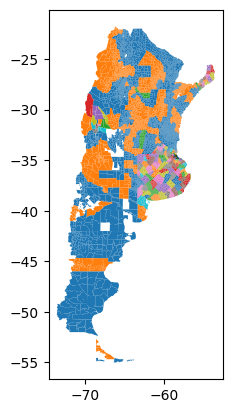

In [8]:
## Plot
gpd.GeoDataFrame(result.merge(radios)).plot('coddepto')


In [9]:
radios.nunique()

PROV_          24
DEPTO_        154
FRACC_         99
COD_2010    52401
IN1           525
geometry    52401
dtype: int64

In [10]:
result.nunique()

codprov        24
coddepto      138
PROV_          24
DEPTO_        154
FRACC_         99
COD_2010    52159
IN1           525
circuito     1974
dtype: int64

#### Guardar resultados

In [11]:
result.to_csv('./info/radios_circuitos-TTGL.csv', index = False)

In [12]:
result.head()

,codprov,coddepto,PROV_,DEPTO_,FRACC_,COD_2010,IN1,circuito
0,01,001,02,001,01,020010101,0214007,00005
1,01,001,02,001,02,020010201,0214007,00005
2,01,001,02,001,02,020010202,0214007,00005
3,01,001,02,001,02,020010203,0214007,00005
4,01,001,02,001,02,020010204,0214007,00005


## Codprov - Coddepto - IN1

In [13]:
pd.options.display.max_rows = 99

In [14]:
## Cuando codprov y coddpto tienen mas de un IN1, elegir el que mas radios tiene en la interseccion.

prov_dpto_nuniques = result.groupby(['codprov', 'coddepto', 'IN1']).nunique().reset_index()
prov_dpto_nuniques['pct'] = prov_dpto_nuniques.groupby(['codprov', 'coddepto'])['COD_2010'].apply(lambda x: x/x.sum()).round(2)
prov_dpto_nuniques['test'] = abs(prov_dpto_nuniques['pct'] - .5)

# test.sort_values('test').head(20).sort_values('IN1')

In [15]:
## Lezama y Chascomus
prov_dpto_nuniques.loc[prov_dpto_nuniques.IN1 == '06217']

,codprov,coddepto,IN1,PROV_,DEPTO_,FRACC_,COD_2010,circuito,pct,test
44,02,030,06217,1,1,11,87,9,1.0,0.5
155,02,135,06217,1,1,3,17,1,1.0,0.5


In [16]:
## Tierra del Fuego
prov_dpto_nuniques.loc[prov_dpto_nuniques.IN1.str[:2] == '94']

,codprov,coddepto,IN1,PROV_,DEPTO_,FRACC_,COD_2010,circuito,pct,test
608,24,01,94014,1,1,7,69,14,1.00,0.50
609,24,02,94007,1,1,11,79,10,0.99,0.49
610,24,02,94014,1,1,1,1,1,0.01,0.49


In [17]:
prov_dpto_IN1 = prov_dpto_nuniques.groupby(['codprov', 'coddepto']).apply(lambda x: x.nlargest(1, 'COD_2010')).reset_index(drop = True)

prov_dpto_IN1[['codprov', 'coddepto', 'IN1']].to_csv('./info/secciones_departamentos-TTGL.csv', index = False)

In [18]:
prov_dpto_IN1[['codprov', 'coddepto', 'IN1']].head()

,codprov,coddepto,IN1
0,01,001,0214007
1,01,002,0214014
2,01,003,0214021
3,01,004,0214028
4,01,005,0214035


## Unir secciones a departamentos IGN

In [31]:
radios = 

,PROV_,DEPTO_,FRACC_,COD_2010,IN1,geometry
0,02,013,03,020130302,0214091,"POLYGON ((-58.46740 -34.53485, -58.46740 -34.5..."
1,02,013,11,020131101,0214091,"POLYGON ((-58.45868 -34.53715, -58.45868 -34.5..."
2,02,013,01,020130104,0214091,"POLYGON ((-58.46758 -34.53733, -58.46794 -34.5..."
3,02,013,01,020130103,0214091,"POLYGON ((-58.46846 -34.53531, -58.46846 -34.5..."
4,02,013,01,020130102,0214091,"POLYGON ((-58.47269 -34.53719, -58.47269 -34.5..."
...,...,...,...,...,...,...
52396,94,014,07,940140705,94014,"POLYGON ((-68.36060 -54.82677, -68.35857 -54.8..."
52397,94,014,07,940140710,94014,"POLYGON ((-68.33741 -54.82805, -68.33741 -54.8..."
52398,94,014,08,940140813,94014,"POLYGON ((-68.33292 -54.82781, -68.33292 -54.8..."
52399,94,014,07,940140709,94014,"POLYGON ((-68.33740 -54.82804, -68.33740 -54.8..."


In [19]:
import geopandas as gpd

# Unir secciones a departamentos IGN
radios_diss_IN1 = radios.copy()
radios_diss_IN1['geometry'] = radios_diss_IN1.buffer(0.001)
radios_diss_IN1 = radios_diss_IN1.dissolve('IN1').reset_index()[['IN1', 'geometry']]

# Si bien en teoria este dissolve nos daria los departmantos, el archivo de radios IGN tiene varios faltantes y errores.
# Por eso es mejor hacer spatial join de los radios disueltos, con la fuente de DPTOS.

### Radios de IGN en DPTOS y PROVS de IGN

In [26]:
## Si este paso falla, se pueden bajar manualmente los archivos y abrirlos localmente.

try: 
    dptos_url = u'https://dnsg.ign.gob.ar/apps/api/v1/capas-sig/Geodesia+y+demarcación/Límites/departamento/json'
    dptos_IGN = gpd.read_file(dptos_url)

    # Agregar código y nombres de provincia
    provs_url = 'https://dnsg.ign.gob.ar/apps/api/v1/capas-sig/Geodesia+y+demarcación/Límites/provincia/json'
    provs_IGN = gpd.read_file(provs_url)

except:
    dptos_IGN = gpd.read_file('./datos/departamento.json')
    provs_IGN = gpd.read_file('./datos/provincia.json')


In [27]:

dptos_IN1_from_radios = radios_diss_IN1

ref_dptos = gpd.overlay(dptos_IGN[['nam', 'in1', 'geometry']], dptos_IN1_from_radios, how='intersection')
ref_dptos['area'] = ref_dptos.area

ref_dptos = ref_dptos.groupby(['nam', 'in1']).apply(lambda x: x.nlargest(1, 'area')).reset_index(drop=True)

provnames = provs_IGN.rename(columns={'in1': 'in1prov', 'nam': 'namprov'})[['in1prov', 'namprov']]
ref_dptos['in1prov'] = ref_dptos['in1'].str[:2]
ref_dptos = ref_dptos.merge(provnames, on='in1prov')

ref_dptos.head()

,nam,in1,IN1,geometry,area,in1prov,namprov
0,12 de Octubre,22036,22036,"POLYGON ((-61.43131 -27.12187, -61.43090 -27.1...",0.251556,22,Chaco
1,1° de Mayo,22126,22126,"POLYGON ((-58.95364 -26.88901, -58.95460 -26.9...",0.111350,22,Chaco
2,2 de Abril,22039,22039,"POLYGON ((-61.02194 -27.54001, -61.02194 -27.5...",0.145755,22,Chaco
3,25 de Mayo,22168,22168,"POLYGON ((-59.80359 -26.44559, -59.80359 -26.4...",0.209987,22,Chaco
4,9 de Julio,22105,22105,"POLYGON ((-61.33226 -26.66029, -61.33371 -26.7...",0.196449,22,Chaco


In [28]:
# Lugares con código diferente (in1, de radios IGN, vs. IN1 de departamentos IGN)
# Son las comunas de CABA, además de Lezama-Chascomús y Tierra del Fuego
ref_dptos.loc[ref_dptos.in1 != ref_dptos.IN1].sort_values('in1')

,nam,in1,IN1,geometry,area,in1prov,namprov
502,Comuna 1,02007,0214007,"POLYGON ((-58.38592 -34.57824, -58.38570 -34.5...",0.001757,02,Ciudad Autónoma de Buenos Aires
509,Comuna 2,02014,0214014,"POLYGON ((-58.38180 -34.57440, -58.38166 -34.5...",0.000621,02,Ciudad Autónoma de Buenos Aires
510,Comuna 3,02021,0214021,"POLYGON ((-58.40939 -34.59811, -58.40869 -34.5...",0.000628,02,Ciudad Autónoma de Buenos Aires
511,Comuna 4,02028,0214028,"POLYGON ((-58.35511 -34.61957, -58.35422 -34.6...",0.002220,02,Ciudad Autónoma de Buenos Aires
512,Comuna 5,02035,0214035,"POLYGON ((-58.42174 -34.59775, -58.42060 -34.5...",0.000655,02,Ciudad Autónoma de Buenos Aires
513,Comuna 6,02042,0214042,"POLYGON ((-58.43150 -34.60496, -58.43063 -34.6...",0.000673,02,Ciudad Autónoma de Buenos Aires
514,Comuna 7,02049,0214049,"POLYGON ((-58.45846 -34.61592, -58.45816 -34.6...",0.001221,02,Ciudad Autónoma de Buenos Aires
515,Comuna 8,02056,0214056,"POLYGON ((-58.44879 -34.65119, -58.44763 -34.6...",0.002211,02,Ciudad Autónoma de Buenos Aires
516,Comuna 9,02063,0214063,"POLYGON ((-58.51904 -34.63303, -58.51904 -34.6...",0.001632,02,Ciudad Autónoma de Buenos Aires
503,Comuna 10,02070,0214070,"POLYGON ((-58.48817 -34.62028, -58.48723 -34.6...",0.001243,02,Ciudad Autónoma de Buenos Aires


### Guardar los resultados

In [29]:
# Geojson
ref_dptos[['in1prov', 'namprov', 'in1', 'nam', 'IN1', 'geometry']].to_file('./mapaelectoral/ref-dptosIGN.geojson', driver='GeoJSON')

# CSV
ref_dptos[['in1prov', 'namprov', 'in1', 'nam', 'IN1']].to_csv('./info/ref-dptosIGN.csv', index=False)